# Thinking of Turnover As A Survival Analysis Problem

Survival analysis involves analyzing the time to a specified event (in this case, employee turnover). 

While it may be more intuitive for thinking of turnover as a survival analysis problem as opposed to a classification one, lack of advanced packages for survival analysis should be taken into consideration. The ones out now are pretty useful, and we can use the lifelines packages to generate valuable insights and visualizations.

In [77]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
data = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
#changing attrition to a numeric value
data['Attrition'] = data['Attrition'].replace({'Yes': 1, 'No': 0})
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


Censoring can be an issue with survival analysis. With left-censored data, the survival duration is less than the observed duration. With right-censored data, the survival duration is longer than the observed duration. For employee turnover, we only consider right-sensored data, which survival analysis usually takes care of. 

The survival probability (probability that an employee will have left at a specifified time, such as 3 years) can be estimated from the data, with the survival probability equaling the product of surviving at a prior time (2 years) and the percentage chance of surviving at 3 years. The result of this function can be shown for possible survival times with a Kaplan-Meier curve:

Text(0.5, 1.0, 'Survival Probabilities for IBM Attrition Dataset')

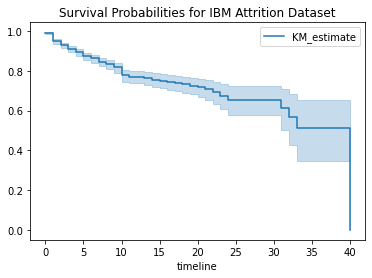

In [78]:
kmf = KaplanMeierFitter()
durations = data.YearsAtCompany
kmf.fit(durations, event_observed=data.Attrition)
kmf.plot()
plt.title('Survival Probabilities for IBM Attrition Dataset')

The Kaplan-Meier Curve can also show differences in category, such as marital status

Text(0.5, 1.0, 'Kaplan-Meier Curves Based on Marital Status')

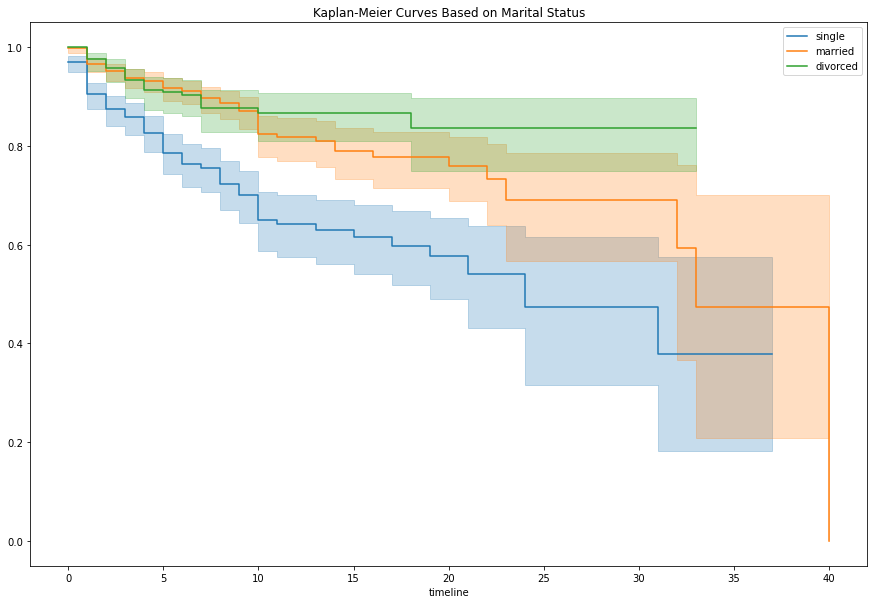

In [79]:
kmf1 = KaplanMeierFitter()

single = data.loc[data.MaritalStatus == 'Single']
married = data.loc[data.MaritalStatus == 'Married']
divorced = data.loc[data.MaritalStatus == 'Divorced']

plt.figure(figsize=(15, 10))
kmf1.fit(single.YearsAtCompany, event_observed=single.Attrition, label='single')
kmf1.plot()
kmf1.fit(married.YearsAtCompany, event_observed=married.Attrition, label='married')
kmf1.plot()
kmf1.fit(divorced.YearsAtCompany, event_observed=divorced.Attrition, label='divorced')
kmf1.plot()
plt.title('Kaplan-Meier Curves Based on Marital Status')



In [80]:
#seeing if there's statistically significant differences
from lifelines.statistics import pairwise_logrank_test

result2 = pairwise_logrank_test(data.YearsAtCompany, data.MaritalStatus, data.Attrition)
result2.print_summary()

#results show statistically significant difference between those married and single, as well as those divorced and single, but not for those divorced and those married.
#Of course, this could be done for all categorical features (ordinal and nominal)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                  test_statistic      p  -log2(p)
Divorced Married            0.81   0.37      1.44
         Single            30.55 <0.005     24.87
Married  Single            38.08 <0.005     30.45

The hazard probability represents the probability than an employee at time t leaves the job at time t. In other words, it reflects the current turnover rate at a specific time. Importantly, this can be derived from the survival function, and vice versa. This is especially important when deriving a survival function from a given hazard function in a Cox Proportional Hazards Model, which is essentially a multiple linear regression of the logarithm of the hazard for n number of features. The idea behind the model is that the hazard for an individual is a linear function of covariates that don't change as time goes by, as well as a population baseline hazard that does change over time. We can test a cox proportional hazards model on this data using 20 features that the feature-selections method in the classification section deemed to be most important (minus Educational Field and Job Role because they were calculated using attrition proportions from the original dataset).

In [82]:
data.BusinessTravel = data.BusinessTravel.map({'Non-Travel':0, 'Travel_Rarely':1, 'Travel_Frequently':2})
data.OverTime = data.OverTime.map({'Yes':1, 'No': 0})
data = pd.get_dummies(data, columns=['Department', 'Gender', 'MaritalStatus'])
data['JobHopIndex'] = (data['NumCompaniesWorked']+1)/(data['TotalWorkingYears']+1)
hazard_columns = ['Attrition','Age', 'BusinessTravel', 'DistanceFromHome', 'EnvironmentSatisfaction', 'JobInvolvement','JobSatisfaction', 'MonthlyIncome', 'NumCompaniesWorked', 'OverTime', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance','YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion','YearsWithCurrManager', 'JobHopIndex', 'MaritalStatus_Single']
data = data[hazard_columns]
data.head()

,Attrition,Age,BusinessTravel,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,OverTime,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobHopIndex,MaritalStatus_Single
0,1,41,1,1,2,3,4,5993,8,1,8,0,1,6,4,0,5,1.000000,1
1,0,49,2,8,3,2,2,5130,1,0,10,3,3,10,7,1,7,0.181818,0
2,1,37,1,2,4,2,3,2090,6,1,7,3,3,0,0,0,0,0.875000,1
3,0,33,2,3,4,3,3,2909,1,1,8,3,3,8,7,3,0,0.222222,0
4,0,27,1,2,1,3,2,3468,9,0,6,3,3,2,2,2,2,1.428571,0


In [83]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(data, duration_col='YearsAtCompany', event_col='Attrition')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1470 total observations, 1233 right-censored observations>
             duration col = 'YearsAtCompany'
                event col = 'Attrition'
      baseline estimation = breslow
   number of observations = 1470
number of events observed = 237
   partial log-likelihood = -1187.77
         time fit was run = 2022-11-08 20:12:35 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
Age                      -0.02       0.98       0.01            -0.04             0.00                 0.96                 1.00
BusinessTravel            0.52       1.68       0.12             0.28             0.76                 1.33                 2.13
DistanceFromHome          0.02       1.02       0.01             0.01             0.04                 1.01                 1.04
EnvironmentSatisfaction  -0.31       0.73       0.06            -0.43            -0.19                 0.65                 0.82
JobInvolvement           -0.35       0.71       0.09            -0.52            -0.17                 0.59                 0.84
JobSatisfaction          -0.38       0.68       0.06            -0.50            -0.26                 0.61                 0.77
MonthlyIncome            -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
NumCompaniesWorked        0.05       1.05       0.05            -0.04             0.14                 0.96                 1.16
OverTime                  1.13       3.09       0.13             0.86             1.39                 2.37                 4.02
TotalWorkingYears        -0.09       0.92       0.03            -0.15            -0.02                 0.86                 0.98
TrainingTimesLastYear    -0.19       0.83       0.06            -0.30            -0.07                 0.74                 0.93
WorkLifeBalance          -0.25       0.78       0.09            -0.43            -0.08                 0.65                 0.93
YearsInCurrentRole       -0.29       0.75       0.03            -0.35            -0.22                 0.70                 0.80
YearsSinceLastPromotion   0.02       1.02       0.03            -0.04             0.08                 0.96                 1.09
YearsWithCurrManager     -0.31       0.73       0.03            -0.38            -0.25                 0.69                 0.78
JobHopIndex               1.35       3.85       0.31             0.74             1.96                 2.10                 7.07
MaritalStatus_Single      0.87       2.39       0.14             0.60             1.14                 1.82                 3.13

                          cmp to     z      p   -log2(p)
covariate                                               
Age                         0.00 -1.90   0.06       4.12
BusinessTravel              0.00  4.31 <0.005      15.92
DistanceFromHome            0.00  2.72   0.01       7.25
EnvironmentSatisfaction     0.00 -5.16 <0.005      21.94
JobInvolvement              0.00 -3.86 <0.005      13.09
JobSatisfaction             0.00 -6.24 <0.005      31.04
MonthlyIncome               0.00 -2.33   0.02       5.65
NumCompaniesWorked          0.00  1.07   0.28       1.82
OverTime                    0.00  8.35 <0.005      53.74
TotalWorkingYears           0.00 -2.56   0.01       6.57
TrainingTimesLastYear       0.00 -3.22 <0.005       9.60
WorkLifeBalance             0.00 -2.79   0.01       7.59
YearsInCurrentRole          0.00 -8.34 <0.005      53.57
YearsSinceLastPromotion     0.00  0.77   0.44       1.18
YearsWithCurrManager        0.00 -9.23 <0.005      65.05
JobHopIndex                 0.00  4.36 <0.005      16.23
MaritalStatus_Single        0.00  6.33 <0.005      31.88
---
Concordance = 0.94
Partial AIC = 2409.54
log-likelihood ratio test = 772.70 on 17 df
-

<AxesSubplot:xlabel='log(HR) (95% CI)'>

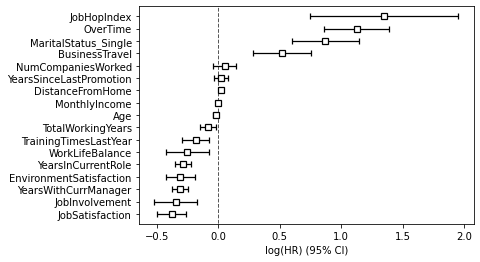

In [84]:
cph.plot()

This plot echoes many of the findings from the classification section, but can also be used a predictive tool:

In [85]:
current_employees = data.loc[data.Attrition == 0]
cph.predict_survival_function(current_employees, conditional_after = current_employees.YearsAtCompany)

,1,3,4,5,6,7,8,9,10,11,...,1459,1460,1462,1463,1464,1465,1466,1467,1468,1469
0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
1.0,9.757898e-01,8.458247e-01,8.487166e-01,9.880634e-01,9.450129e-01,8.905573e-01,9.686855e-01,9.951130e-01,9.853711e-01,8.812966e-01,...,9.103802e-01,8.707211e-01,9.806272e-01,9.256025e-01,8.708835e-01,9.896102e-01,9.955969e-01,6.844056e-01,9.872767e-01,9.831891e-01
2.0,9.757898e-01,4.941307e-01,6.529948e-01,9.713129e-01,8.769785e-01,7.641193e-01,9.430563e-01,9.881958e-01,9.442098e-01,7.922661e-01,...,8.206925e-01,5.831798e-01,9.400004e-01,8.672156e-01,7.475498e-01,9.601319e-01,9.893610e-01,4.491454e-01,9.766793e-01,9.649481e-01
3.0,9.405809e-01,3.141232e-01,3.955287e-01,9.194368e-01,7.782670e-01,5.982439e-01,9.430563e-01,9.663140e-01,9.005020e-01,7.922661e-01,...,6.078033e-01,3.736334e-01,8.894009e-01,8.672156e-01,4.804130e-01,9.284169e-01,9.696056e-01,2.465622e-01,9.766793e-01,9.140187e-01
4.0,8.983907e-01,3.141232e-01,2.273381e-01,8.778734e-01,6.193717e-01,3.746482e-01,9.058909e-01,9.482488e-01,8.417370e-01,6.753333e-01,...,4.354126e-01,1.982140e-01,8.342834e-01,7.864941e-01,2.939823e-01,8.850588e-01,9.532625e-01,3.595990e-02,9.610015e-01,8.605934e-01
5.0,8.708817e-01,1.592531e-01,4.574065e-02,8.778734e-01,4.812828e-01,2.234133e-01,8.615288e-01,9.482488e-01,6.777872e-01,5.532365e-01,...,2.707939e-01,2.590317e-02,8.342834e-01,6.961571e-01,1.460908e-01,7.590930e-01,9.532625e-01,7.098177e-03,9.417760e-01,7.898674e-01
6.0,8.378811e-01,6.818351e-02,7.705564e-03,8.190438e-01,2.318474e-01,5.000817e-02,8.327084e-01,9.217911e-01,5.646772e-01,4.833054e-01,...,5.895402e-02,4.661247e-03,8.342834e-01,6.409142e-01,1.547804e-02,6.669595e-01,9.292709e-01,7.098177e-03,9.289670e-01,5.997872e-01
7.0,8.006570e-01,3.837323e-02,6.101802e-04,7.510825e-01,1.030083e-01,9.483597e-03,7.982479e-01,8.897850e-01,5.646772e-01,4.086206e-01,...,1.631077e-02,4.661247e-03,8.342834e-01,5.783586e-01,2.333805e-03,6.669595e-01,9.001566e-01,6.230174e-04,9.132985e-01,4.755921e-01
8.0,7.643060e-01,1.878978e-02,1.778315e-07,7.082635e-01,3.244937e-02,8.889053e-04,7.595301e-01,8.687303e-01,4.294387e-01,3.353978e-01,...,1.631077e-02,3.561290e-04,8.342834e-01,5.125395e-01,2.333805e-03,5.493322e-01,8.809475e-01,2.985170e-05,8.952043e-01,4.755921e-01
9.0,7.280609e-01,8.111799e-03,1.863516e-10,6.584591e-01,7.957941e-04,4.451219e-07,7.218836e-01,8.432695e-01,3.050851e-01,2.740776e-01,...,2.375208e-03,1.434957e-05,8.342834e-01,4.529798e-01,1.367755e-04,4.311281e-01,8.576567e-01,3.808840e-06,8.770742e-01,3.358477e-01


<AxesSubplot:>

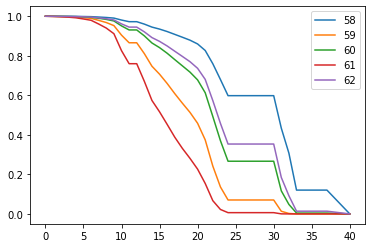

In [89]:
training_rows = current_employees.iloc[45:50]
cph.predict_survival_function(training_rows).plot()